In [78]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
ny_map = pd.read_json("ny_map_data_res80.json")

In [4]:
len(ny_map)

6400

In [5]:
ny_map.head()

,county_name,lat,lng,state
0,Pike,41.403671,-74.984937,PA
1,Kawartha Lakes,44.788228,-79.055823,ON
2,Montgomery,42.920886,-74.476076,NY
3,Chautauqua,42.162278,-79.666456,NY
4,Rensselaer,42.862532,-73.661899,NY


In [179]:
ny_map["lng_rank"] = ny_map.lng.rank(method = "dense")
ny_map["lat_rank"] = ny_map.lat.rank(method = "dense")

In [180]:
ny_map["nyc"] = ny_map.county_name.map(lambda x: x in ["New York", "Bronx", "Richmond", "Kings", "Queens"])

In [181]:
ny_map_restricted = ny_map[ny_map.state == "NY"]

In [182]:
ny_map_restricted.groupby("county_name").count().sort_values("lat").head()

,lat,lng,state,lng_rank,lat_rank,nyc
county_name,,,,,,
New York,1,1,1,1,1,1
Bronx,2,2,2,2,2,2
Richmond,3,3,3,3,3,3
Kings,4,4,4,4,4,4
Queens,5,5,5,5,5,5


In [183]:
ny_map[ny_map.county_name == "Kings"]

,county_name,lat,lng,state,lng_rank,lat_rank,nyc
2491,Kings,40.645063,-73.967215,NY,59.0,4.0,True
2959,Kings,40.645063,-73.865443,NY,60.0,4.0,True
5992,Kings,40.703418,-73.967215,NY,59.0,5.0,True
6332,Kings,40.586709,-73.967215,NY,59.0,3.0,True


In [184]:
ny_map[ny_map.county_name == "Queens"]

,county_name,lat,lng,state,lng_rank,lat_rank,nyc
157,Queens,40.703418,-73.865443,NY,60.0,5.0,True
1205,Queens,40.761772,-73.865443,NY,60.0,6.0,True
3393,Queens,40.645063,-73.763671,NY,61.0,4.0,True
3554,Queens,40.703418,-73.763671,NY,61.0,5.0,True
4335,Queens,40.761772,-73.763671,NY,61.0,6.0,True


In [185]:
sns.set_style("dark")

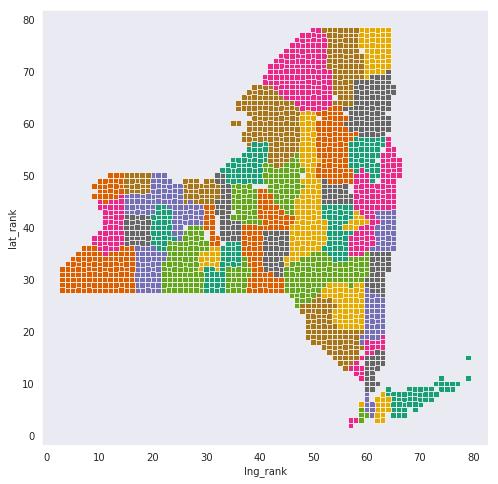

In [186]:
fig, ax = plt.subplots(figsize = (8, 8))

ax = sns.scatterplot(data = ny_map_restricted, x = "lng_rank", y = "lat_rank", hue = "county_name", marker = "s", palette = "Dark2", s = 35)

ax.legend_.remove()

In [187]:
ag_df = pd.read_csv("./election_results.csv")

In [188]:
county_totals = ag_df[~(ag_df.county == "All")].groupby(["county"], as_index = False)["ttl"].sum()

In [233]:
county_totals["pre_mult"] = county_totals.ttl / county_totals.ttl.min()

In [234]:
len(county_totals)

62

In [235]:
county_totals.sort_values("pre_mult", ascending = False).head()

,county,ttl,mult,pre_mult
23,Kings,296159,1282.073593,1282.073593
30,New York,236022,1021.740260,1021.740260
40,Queens,182995,792.186147,792.186147
2,Bronx,125978,545.359307,545.359307
59,Westchester,85187,368.774892,368.774892


In [236]:
county_totals["county"] = county_totals.county.astype("str").map(lambda x: x.replace(".", " "))

In [237]:
ny_map_county_ttl = ny_map_restricted.merge(right = county_totals, left_on = ["county_name"], right_on = ["county"], how = "left")

In [238]:
len(ny_map_county_ttl[pd.isnull(ny_map_county_ttl.ttl)])

0

In [239]:
get_bounds = lambda x: (
    ny_map_restricted
        .groupby(["county_name"], as_index = False)
        .agg({i: x for i in ["lng_rank", "lat_rank"]})
        .rename(columns = {i: "{}_{}".format(x, i) for i in ["lng_rank", "lat_rank"]})
)

In [240]:
num_squares = ny_map_restricted.groupby(["county_name"], as_index = False)["lng"].count().rename(columns = {"lng": "num_squares"})

In [241]:
county_shapes = (get_bounds("min")
    .merge(right = get_bounds("max"), on = ["county_name"], how = "left")
    .merge(right = num_squares, on = ["county_name"], how = "left"))

In [242]:
for i in ["lng", "lat"]:
    county_shapes["mid_{}_rank".format(i)] = (county_shapes["min_{}_rank".format(i)] +
        ((county_shapes["max_{}_rank".format(i)] - county_shapes["min_{}_rank".format(i)]) / 2))

In [243]:
ny_map_county_shapes = ny_map_county_ttl.merge(right = county_shapes, on = ["county_name"], how= "left")

In [244]:
ny_map_county_shapes["mult"] = ny_map_county_shapes.pre_mult / ny_map_county_shapes.num_squares
ny_map_county_shapes["sqrt_mult"] = ny_map_county_shapes.mult.map(lambda x: np.sqrt(x))

In [245]:
ny_map_county_shapes[ny_map_county_shapes.nyc].head()

,county_name,lat,lng,state,lng_rank,lat_rank,nyc,county,ttl,mult,pre_mult,min_lng_rank,min_lat_rank,max_lng_rank,max_lat_rank,num_squares,mid_lng_rank,mid_lat_rank,sqrt_mult
52,Queens,40.703418,-73.865443,NY,60.0,5.0,True,Queens,182995,158.437229,792.186147,60.0,4.0,61.0,6.0,5,60.5,5.0,12.587185
431,Queens,40.761772,-73.865443,NY,60.0,6.0,True,Queens,182995,158.437229,792.186147,60.0,4.0,61.0,6.0,5,60.5,5.0,12.587185
444,Bronx,40.878481,-73.865443,NY,60.0,8.0,True,Bronx,125978,272.679654,545.359307,60.0,7.0,60.0,8.0,2,60.0,7.5,16.513015
846,Richmond,40.586709,-74.068987,NY,58.0,3.0,True,Richmond,25851,37.303030,111.909091,57.0,2.0,58.0,3.0,3,57.5,2.5,6.107621
911,Kings,40.645063,-73.967215,NY,59.0,4.0,True,Kings,296159,320.518398,1282.073593,59.0,3.0,60.0,5.0,4,59.5,4.0,17.903028


In [246]:
for i in ["lng", "lat"]:
    ny_map_county_shapes["scaled_{}_rank".format(i)] = ny_map_county_shapes.apply(
        lambda x: x["{}_rank".format(i)] + x["sqrt_mult"] * (x["{}_rank".format(i)] - x["mid_{}_rank".format(i)]),
        axis = 1)

In [247]:
ny_map_county_shapes[ny_map_county_shapes.nyc].head()

,county_name,lat,lng,state,lng_rank,lat_rank,nyc,county,ttl,mult,...,min_lng_rank,min_lat_rank,max_lng_rank,max_lat_rank,num_squares,mid_lng_rank,mid_lat_rank,sqrt_mult,scaled_lng_rank,scaled_lat_rank
52,Queens,40.703418,-73.865443,NY,60.0,5.0,True,Queens,182995,158.437229,...,60.0,4.0,61.0,6.0,5,60.5,5.0,12.587185,53.706407,5.000000
431,Queens,40.761772,-73.865443,NY,60.0,6.0,True,Queens,182995,158.437229,...,60.0,4.0,61.0,6.0,5,60.5,5.0,12.587185,53.706407,18.587185
444,Bronx,40.878481,-73.865443,NY,60.0,8.0,True,Bronx,125978,272.679654,...,60.0,7.0,60.0,8.0,2,60.0,7.5,16.513015,60.000000,16.256507
846,Richmond,40.586709,-74.068987,NY,58.0,3.0,True,Richmond,25851,37.303030,...,57.0,2.0,58.0,3.0,3,57.5,2.5,6.107621,61.053810,6.053810
911,Kings,40.645063,-73.967215,NY,59.0,4.0,True,Kings,296159,320.518398,...,59.0,3.0,60.0,5.0,4,59.5,4.0,17.903028,50.048486,4.000000


In [248]:
ny_map_county_shapes["sqrt_mult_int"] = ny_map_county_shapes.sqrt_mult.astype("int")

In [249]:
nyc_map_county_shapes = ny_map_county_shapes[ny_map_county_shapes.nyc]

In [250]:
nyc_map_county_shapes.head()

,county_name,lat,lng,state,lng_rank,lat_rank,nyc,county,ttl,mult,...,min_lat_rank,max_lng_rank,max_lat_rank,num_squares,mid_lng_rank,mid_lat_rank,sqrt_mult,scaled_lng_rank,scaled_lat_rank,sqrt_mult_int
52,Queens,40.703418,-73.865443,NY,60.0,5.0,True,Queens,182995,158.437229,...,4.0,61.0,6.0,5,60.5,5.0,12.587185,53.706407,5.000000,12
431,Queens,40.761772,-73.865443,NY,60.0,6.0,True,Queens,182995,158.437229,...,4.0,61.0,6.0,5,60.5,5.0,12.587185,53.706407,18.587185,12
444,Bronx,40.878481,-73.865443,NY,60.0,8.0,True,Bronx,125978,272.679654,...,7.0,60.0,8.0,2,60.0,7.5,16.513015,60.000000,16.256507,16
846,Richmond,40.586709,-74.068987,NY,58.0,3.0,True,Richmond,25851,37.303030,...,2.0,58.0,3.0,3,57.5,2.5,6.107621,61.053810,6.053810,6
911,Kings,40.645063,-73.967215,NY,59.0,4.0,True,Kings,296159,320.518398,...,3.0,60.0,5.0,4,59.5,4.0,17.903028,50.048486,4.000000,17


In [254]:
def ny_scatter(df):
    fig, ax = plt.subplots(figsize = (8, 8))
    for county in df.county_name.unique():
        county_df = df[df.county_name == county]
        ax.scatter(
            y = county_df.scaled_lat_rank,
            x = county_df.scaled_lng_rank,
            s = county_df.mult * 2,
            marker = "s",
            label = county)
    # ax.legend(loc = 9, bbox_to_anchor = (0.5,0))
    return fig

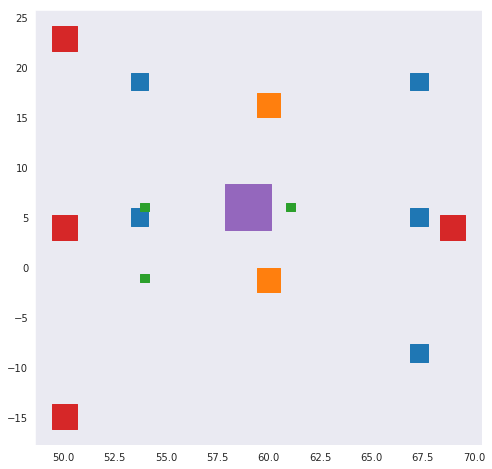

In [255]:
fig = ny_scatter(ny_map_county_shapes[ny_map_county_shapes.nyc])

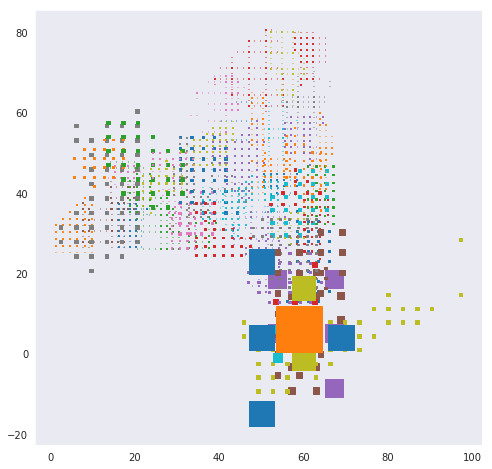

In [256]:
fig = ny_scatter(ny_map_county_shapes)